# Shluková analýza

## Dataset pro tuto metodu dolování dat
Tento dataset obsahuje informace o 344 tučňákcích žijících na ostrově Palmer Archipelago na Antakrtidě. Každý tučňák patří do jednoho ze 3 možných druhů:Adélie, Gentoo, Chinstrap, dále jsou popsáni pomocí dalších 6 atributu jako ostrov, na kterém žijí, pohlaví, vaha a míry zobáku. 

https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?select=penguins_size.csv

In [1]:
import pandas as pd

df = pd.read_csv( "datasets/penguins_size.csv")
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [3]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

### Dataset se upraví pro shlukovou analýzu  a odstraní se chybějící hodnoty.

In [4]:
#zbavime se NaN hodnot
df = df.dropna()
df = df[df.sex!='.']
#nahradime kategoricke atrubity s ciselnymi hodnotami
island_map = {"Biscoe": 0, "Dream": 1, "Torgersen": 2}
sex_map = {"MALE": 0, "FEMALE": 1}
df = df.applymap(lambda s: island_map.get(s) if s in island_map else s)
df = df.applymap(lambda s: sex_map.get(s) if s in sex_map else s)

df.describe()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,0.651652,43.992793,17.164865,200.966967,4207.057057,0.495495
std,0.714715,5.468668,1.969235,14.015765,805.215802,0.500732
min,0.000000,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,0.000000,39.500000,15.600000,190.000000,3550.000000,0.000000
50%,1.000000,44.500000,17.300000,197.000000,4050.000000,0.000000
75%,1.000000,48.600000,18.700000,213.000000,4775.000000,1.000000
max,2.000000,59.600000,21.500000,231.000000,6300.000000,1.000000


## Použití knihovny scikit-learn

In [5]:
from sklearn.preprocessing import normalize

#odtraneni 1. sloupce, ktery tridy tucnaky a normalizace datasetu
X = df[df.columns[1:]]
X_normalized = normalize(X, norm='max')

## K - MEANS

In [6]:
from sklearn.cluster import KMeans
#hledani hodnoty pro kolik bude potreba shluku
c_errs = []
for i in range(1, 15):
  kmeans = KMeans(i, n_init = 10 )
  kmeans.fit(X_normalized)
  c_errs.append(kmeans.inertia_)
clusters_df = pd.DataFrame({ "clusters_num": range(1, 15), "cluster_errors": c_errs })
clusters_df[0:15]

,clusters_num,cluster_errors
0,1,0.015719
1,2,0.005262
2,3,0.002862
3,4,0.001936
4,5,0.001421
5,6,0.001181
6,7,0.001009
7,8,0.000881
8,9,0.000767
9,10,0.000700


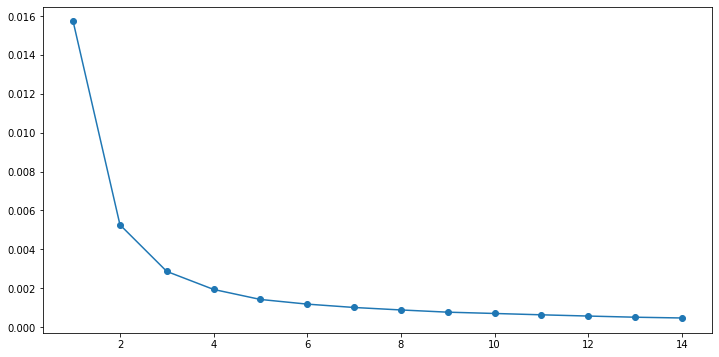

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
plt.plot(clusters_df['clusters_num'], clusters_df['cluster_errors'], marker = "o" )

Vidime, ze optimalni hodnota pro cluster je 3

In [8]:
kmeans = KMeans(n_clusters=3)
kmeans_clusters = kmeans.fit_predict(X_normalized)

Porovname s originalnim datasetem

<AxesSubplot:title={'center':'scikit-learn k-Means'}, xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

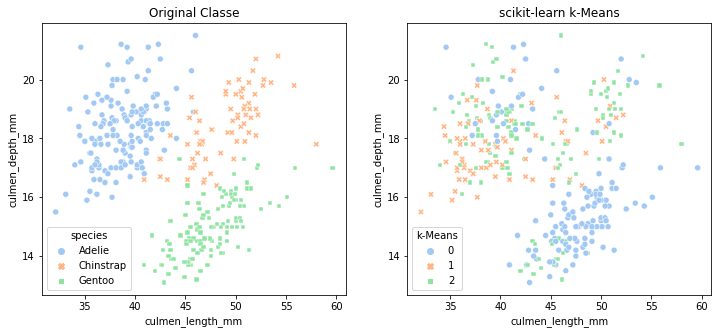

In [9]:
df_scikit= df.copy(deep=True)
df_scikit['k-Means'] = kmeans_clusters

plt.figure(figsize=(12,5))
plt.subplot(1,2,1).set_title('Original Classe')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='species', style='species', palette= 'pastel',data=df)
plt.subplot(1,2,2).set_title('scikit-learn k-Means')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='k-Means', style='k-Means', palette= 'pastel' ,data=df_scikit)

In [10]:
print('Original data classes:')
print(df['species'].value_counts())
print('-----------------------------')
print('Predicted data classes:')
print(df_scikit['k-Means'].value_counts())

Original data classes:
Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64
-----------------------------
Predicted data classes:
0    134
2    127
1     72
Name: k-Means, dtype: int64


## Agglomerative Clustering

In [11]:
from sklearn.cluster import AgglomerativeClustering
#minimalni vzdalenost je nastavena na 0, tu pak urcime, vykreslenim dendogramu, pro spravnou predikci do shluku
agg = AgglomerativeClustering(linkage='average', distance_threshold=0, n_clusters=None)
#trenovani a predikce
agg_cluster = agg.fit_predict(X_normalized)

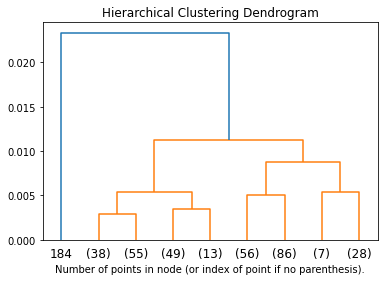

In [12]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np
#vykresleni dendogramu, pravzato z https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [13]:
#vytvoreni noveho modelu s nastvenou minimalni vzdalenosti 0.008
agg1 = AgglomerativeClustering(linkage='average', distance_threshold=0.008, n_clusters=None)
#trenovani a predikce
agg_cluster1 = agg1.fit_predict(X_normalized)

Porovnani s originalnim datasetem

<AxesSubplot:title={'center':'scikit-learn Agglomerative Clustering'}, xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

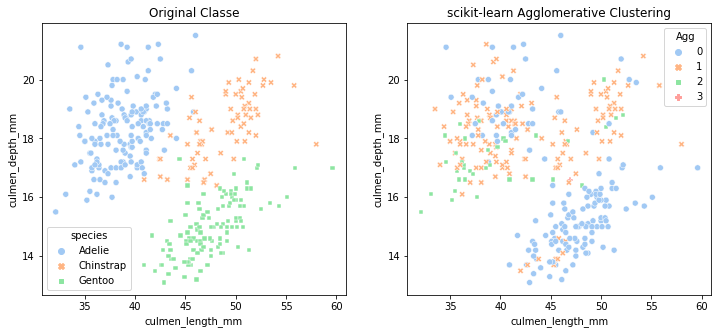

In [14]:
df_scikit['Agg'] = agg_cluster1
plt.figure(figsize=(12,5))
plt.subplot(1,2,1).set_title('Original Classe')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='species', style='species', palette= 'pastel',data=df)
plt.subplot(1,2,2).set_title('scikit-learn Agglomerative Clustering')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='Agg', style='Agg', palette= 'pastel' ,data=df_scikit)

In [15]:
print('Original data classes:')
print(df['species'].value_counts())
print('-----------------------------')
print('Predicted data classes:')
print(df_scikit['Agg'].value_counts())

Original data classes:
Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64
-----------------------------
Predicted data classes:
0    155
1    142
2     35
3      1
Name: Agg, dtype: int64


Lze vidět, že existuje jeden bod (tučňák), který tvoří samostaný shluk, jedná se o odlehlou hodnotu tzv. šum.

## DBSCAN

In [54]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#DBSCAN prijma dva parametry a to epsilon, velikost okoli a minimalni pocet bodu v okoli, musi se nejdriv najit optimalni parametry
#vypocitame pomoci tridy NearestNeighbors() vzdalenost k-nejblizsich sousedu
nn = NearestNeighbors(n_neighbors=3)
neighbors = nn.fit(X_normalized)
dist, i = neighbors.kneighbors(X_normalized)

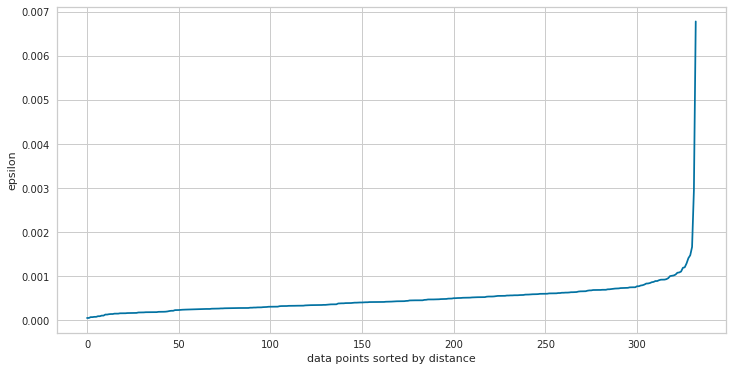

In [55]:
#vykresleni K-distance grafu pro optimalni okoli
dist = np.sort(dist, axis=0)
dist = dist[:,1]

plt.figure(figsize=(12,6))
plt.plot(dist)
plt.xlabel("data points sorted by distance")
plt.ylabel("epsilon")
plt.savefig("dbscan.svg", format="svg")

In [18]:
dbscan = DBSCAN(eps=0.0015, min_samples=24)
#trenovani a zarazani
dbscan_clusters = dbscan.fit_predict(X_normalized)

Porovani s originalnim datasetem

<AxesSubplot:title={'center':'scikit-learn DBSCAN'}, xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

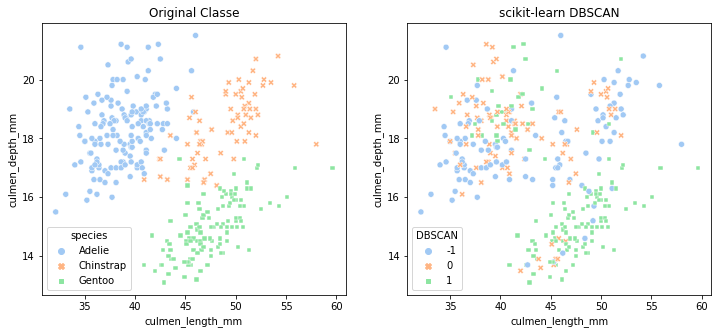

In [19]:
df_scikit['DBSCAN'] = dbscan_clusters
plt.figure(figsize=(12,5))
plt.subplot(1,2,1).set_title('Original Classe')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='species', style='species', palette= 'pastel',data=df)
plt.subplot(1,2,2).set_title('scikit-learn DBSCAN')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='DBSCAN', style='DBSCAN', palette= 'pastel' ,data=df_scikit)

In [20]:
print('Original data classes:')
print(df['species'].value_counts())
print('-----------------------------')
print('Predicted data classes:')
print(df_scikit['DBSCAN'].value_counts())

Original data classes:
Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64
-----------------------------
Predicted data classes:
 1    131
-1    111
 0     91
Name: DBSCAN, dtype: int64


## Použití knihovny mlxtend

## K-Means

In [21]:
from mlxtend.preprocessing import minmax_scaling

#Normalizace datasetu
X_mlxtend_normalized = minmax_scaling(X.values, columns=[0, 1, 2, 3, 4, 5])

In [22]:
import mlxtend.cluster
#vytvoreni modelu, trenovani a zarazeni
kmeans_mlxtend = mlxtend.cluster.Kmeans(k=3)
kmeans_mlxtend.fit(X_normalized)
kmeans_mlxtend_clusters = kmeans_mlxtend.predict(X_normalized)

Porovnani s originalnim datasetem

<AxesSubplot:title={'center':'Mlxtend k-Means'}, xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

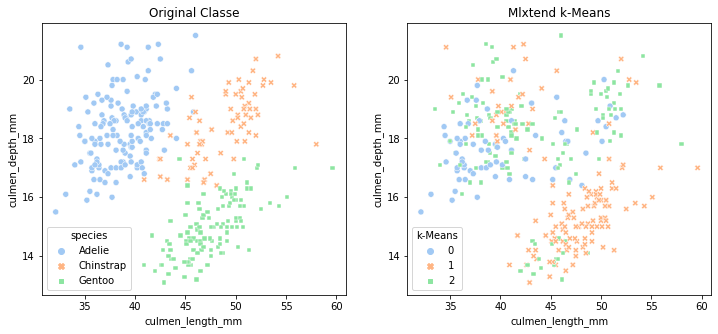

In [23]:
df_mlxtend= df.copy(deep=True)
df_mlxtend['k-Means'] = kmeans_mlxtend_clusters
plt.figure(figsize=(12,5))
plt.subplot(1,2,1).set_title('Original Classe')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='species', style='species', palette= 'pastel',data=df)
plt.subplot(1,2,2).set_title('Mlxtend k-Means')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='k-Means', style='k-Means', palette= 'pastel',data=df_mlxtend)

In [24]:
print('Original data classes:')
print(df['species'].value_counts())
print('-----------------------------')
print('Predicted data classes:')
print(df_mlxtend['k-Means'].value_counts())

Original data classes:
Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64
-----------------------------
Predicted data classes:
1    134
2    127
0     72
Name: k-Means, dtype: int64


## Použití knihovny PyCaret

In [25]:
from pycaret.clustering import *

In [26]:
#predzpracovani dat, nastavi se normalizace na true, ktery atribut se ma ignorovat, aby se provedla shlukova analyza na jeho zaklade a interaktivni mod vypnuty 
exp = setup(df, normalize=True, ignore_features=['species'], silent=True)

,Description,Value
0,session_id,184
1,Original Data,"(333, 7)"
2,Missing Values,False
3,Numeric Features,4
4,Categorical Features,2
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(333, 9)"
9,CPU Jobs,-1


## K-Means

In [27]:
#vytvoreni modelu, trenovani a predikce
k_means = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3809,260.5776,1.0267,0,0,0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


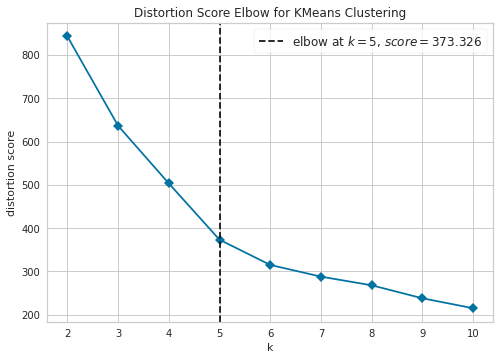

In [28]:
#vykresleni grafu pro nepresnot v zavislosti na shluku
plot_model(k_means, 'elbow')

Jsou 3 druhy tucnaku, ale PyCaret nabizi 5 sluku jako optimalni hodnotu

In [29]:
k_means2 = create_model('kmeans', num_clusters = 5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4148,291.32,0.9862,0,0,0


In [58]:
plot_model(k_means2, 'cluster', scale=1)

In [31]:
#prideleni datasetu jendotlive shluky
k_means2_results=assign_model(k_means2)

Porovani s originalnim datasetem

<AxesSubplot:title={'center':'PyCaret k-Means'}, xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

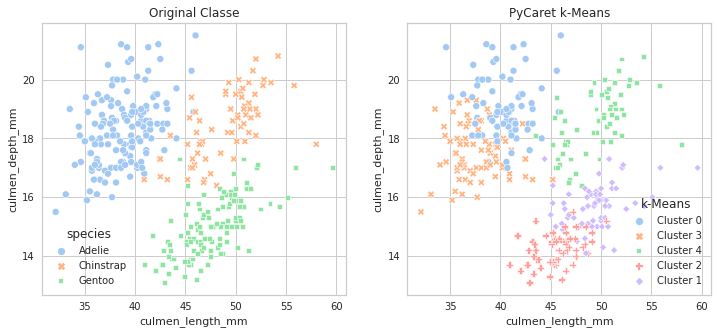

In [32]:
#porovnani originalni dataset s modelem k-means od PyCaretu
df_PyCaret = df.copy()
df_PyCaret['k-Means'] = k_means2_results['Cluster']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
plt.subplot(1,2,1).set_title('Original Classe')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='species', style='species', palette= 'pastel',data=df)
plt.subplot(1,2,2).set_title('PyCaret k-Means')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='k-Means', style='k-Means', palette= 'pastel' ,data=df_PyCaret)

In [33]:
print('Original data classes:')
print(df['species'].value_counts())
print('-----------------------------')
print('Predicted data classes:')
print(df_PyCaret['k-Means'].value_counts())

Original data classes:
Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64
-----------------------------
Predicted data classes:
Cluster 3    78
Cluster 0    74
Cluster 4    62
Cluster 1    61
Cluster 2    58
Name: k-Means, dtype: int64


## Agglomerative Clustering

In [34]:
#vytvoreni, trenovani modelu
hclust = create_model('hclust')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4029,255.9719,1.1039,0,0,0


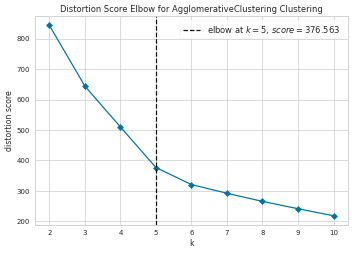

In [35]:
plot_model(hclust, 'elbow', scale=0.7)

In [36]:
hclust = create_model('hclust', num_clusters=5)
#prideleni datasetu jendotlive shluky
hclust_results=assign_model(hclust)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.413,288.1105,0.9897,0,0,0


Porovnani s originalnim datasetem

<AxesSubplot:title={'center':'PyCaret Agglomerative Clustering'}, xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

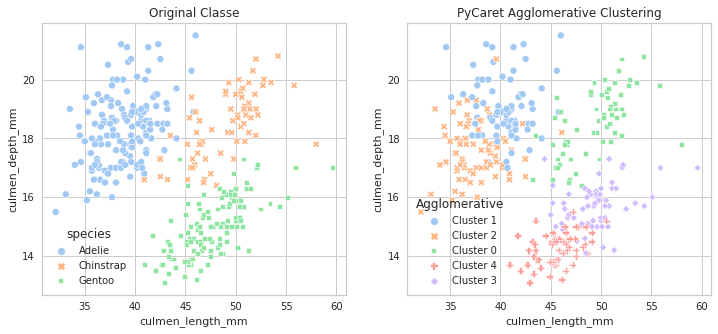

In [37]:
#porovnani originalni dataset s modelem Agglomerative Clustering od PyCaretu
df_PyCaret['Agglomerative'] = hclust_results['Cluster']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1).set_title('Original Classe')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='species', style='species', palette= 'pastel',data=df)
plt.subplot(1,2,2).set_title('PyCaret Agglomerative Clustering')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='Agglomerative', style='Agglomerative', palette= 'pastel' ,data=df_PyCaret)

In [38]:
print('Original Data Classes:')
print(df.species.value_counts())
print('-' * 30)
print('Predicted Data Classes:')
print(df_PyCaret['Agglomerative'].value_counts())

Original Data Classes:
Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64
------------------------------
Predicted Data Classes:
Cluster 2    78
Cluster 1    73
Cluster 0    63
Cluster 3    61
Cluster 4    58
Name: Agglomerative, dtype: int64


## DBSCAN

In [39]:
dbscan = create_model('dbscan')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0874,57.6482,1.425,0,0,0


In [40]:
plot_model(dbscan, plot='cluster')

In [41]:
dbscan_results=assign_model(dbscan)

In [42]:
df_PyCaret['DBSCAN'] = dbscan_results['Cluster']

Porovani s originalnim datasetem

<AxesSubplot:title={'center':'PyCaret DBSCAN'}, xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

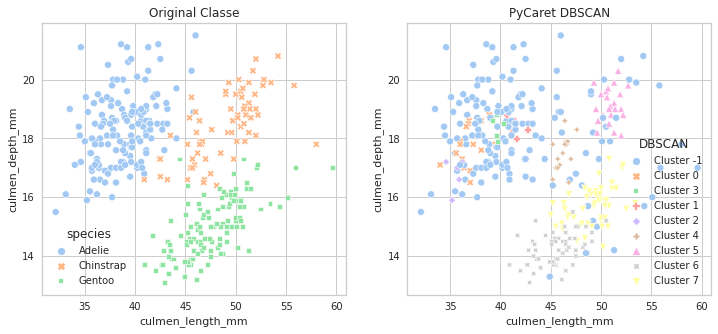

In [43]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1).set_title('Original Classe')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='species', style='species', palette= 'pastel',data=df)
plt.subplot(1,2,2).set_title('PyCaret DBSCAN')
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue='DBSCAN', style='DBSCAN', palette= 'pastel' ,data=df_PyCaret)

In [44]:
print('Original Data Classes:')
print(df['species'].value_counts())
print('-' * 30)
print('Predicted Data Classes:')
print(df_PyCaret['DBSCAN'].value_counts())

Original Data Classes:
Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64
------------------------------
Predicted Data Classes:
Cluster -1    157
Cluster 6      57
Cluster 7      50
Cluster 5      23
Cluster 0      16
Cluster 4      15
Cluster 3       5
Cluster 1       5
Cluster 2       5
Name: DBSCAN, dtype: int64
